In [2]:
import os
import random
os.getcwd()

'/home/rajan/Desktop/thesis/thesis_work/minimalist_diffusion'

In [3]:
epoch_ = 0
dataset_path = '/home/rajan/Desktop/thesis/thesis_work'
model_preloading_path = '/home/rajan/Desktop/thesis/thesis_work/minimalist_diffusion_ckpts/mode_28_ckpt.pth'
model_checkpoint_path = f'/home/rajan/Desktop/thesis/thesis_work/minimalist_drl_ckpts/mode_{epoch_}_ckpt.pth'

In [4]:
from minimalist_diff_rl_model import minimalDiffRl
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam
from collections import OrderedDict
import torchvision.transforms as transforms
import numpy as np


/home/rajan/miniconda3/envs/thesisnew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [6]:
set_seed(236)

Random seed set as 236


In [17]:

#Setting up the parameters
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
last_epoch = 1122
num_epochs = 20
learning_rate = 1e-4
model = torch.nn.DataParallel(minimalDiffRl())
model = model.to(device = device)
model_last_trained_path = f'/home/rajan/Desktop/thesis/thesis_work/minimalist_diffusion_ckpts/mode_{last_epoch}_ckpt.pth'
#load the pretrained  DiffusionNet from the checkpoint --> Note that models are being saved in the form of Datparallel objects
#so --> need to bring in a new dictionary -> 
#approach taken from : https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/4

new_state_dict = OrderedDict()

"""loading parameters for the diffusion net"""

# ckpt = torch.load(model_preloading_path)
# for k, v in ckpt.items():
#     name = k[7:] # remove module.
#     new_state_dict[name] = v

# model.module.encoder_drl.load_state_dict(new_state_dict)


"""loading parameters for continual learning"""
ckpt_last = torch.load(model_last_trained_path)
model.load_state_dict(ckpt_last)

    
optimizer = Adam(model.parameters(), learning_rate)

#defining the loss function 
def loss_fn(model: minimalDiffRl, x1:torch.tensor, alpha_tensor:torch.tensor):
    """model : minimalDiffRl object wtih alpha embeddings
       x     : input image
    """
    x0 = torch.randn_like(x1).to(device)
    alpha = torch.randn(batch_size,).uniform_(0,1).to(device)
    blended_x  = (1.-alpha.view(-1,1,1,1))*x0 + alpha.view(-1,1,1,1)*x1
    model_output = model(blended_x, alpha)

    loss = torch.mean(torch.square(model_output - (x1-x0)))
    return loss


datasets = MNIST(dataset_path,train=True,transform=transforms.ToTensor(),download=False)
data_loader = DataLoader(dataset=datasets,batch_size=batch_size,shuffle=True,num_workers=4)
t = torch.ones(batch_size).to(device=device)
#Training loop 
for epoch in range(last_epoch, last_epoch+num_epochs):
    avg_loss = 0
    num_items = 0
    for i , (x, y) in enumerate(data_loader):
        if x.shape[0] != batch_size:
            continue
        x = x.to(device)
        loss = loss_fn(model,x,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_items += x.shape[0]
        avg_loss += loss.item() * x.shape[0]
    print(f'Epoch number : {epoch}')
    print('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
    torch.save(model.state_dict(),f'/home/rajan/Desktop/thesis/thesis_work/minimalist_diffusion_ckpts/mode_{epoch}_ckpt.pth')
    epoch_ += 1


Epoch number : 1122
Average Loss: 0.346014
Epoch number : 1123
Average Loss: 0.345353
Epoch number : 1124
Average Loss: 0.346414
Epoch number : 1125
Average Loss: 0.345710
Epoch number : 1126
Average Loss: 0.345858
Epoch number : 1127
Average Loss: 0.345952
Epoch number : 1128
Average Loss: 0.345954
Epoch number : 1129
Average Loss: 0.345719
Epoch number : 1130
Average Loss: 0.345552
Epoch number : 1131
Average Loss: 0.346020
Epoch number : 1132
Average Loss: 0.345777
Epoch number : 1133
Average Loss: 0.345736
Epoch number : 1134
Average Loss: 0.346221
Epoch number : 1135
Average Loss: 0.345536
Epoch number : 1136
Average Loss: 0.345632
Epoch number : 1137
Average Loss: 0.345764
Epoch number : 1138
Average Loss: 0.345670
Epoch number : 1139
Average Loss: 0.345675
Epoch number : 1140
Average Loss: 0.345790
Epoch number : 1141
Average Loss: 0.345536


Random seed set as 236


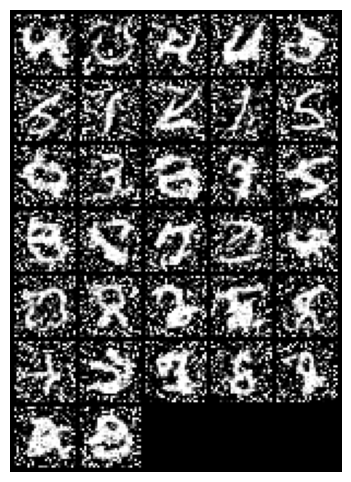

In [7]:

from torchvision.utils import make_grid
import numpy as np
import torch

set_seed(236)

device = 'cpu'
last_epoch = 1141
time_steps = 128

#define an alpha schedule 
def alpha_linear_schedule(steps):
    """steps : number of steps
    """
    return torch.linspace(0,1,steps).to(device=device)

def cosine_schedule(alpha_schedule):
    """alpha_schedule : a linear alpha schedule of t/T where T : max non of steps
    """
    return 1. - torch.cos(alpha_schedule * (torch.pi/2.)).to(device=device)
    
#for sampling procedure
alpha_schedule = alpha_linear_schedule(time_steps)

# Need to check the sampling step --> 
#Sampling steps 
def sampler(alpha_schedule,model):

    x_alpha = torch.randn(32,1,28,28).to(device=device)
    t = torch.ones(x_alpha.shape[0]).to(device=device)
    for i  in range(1,len(alpha_schedule)):
        alpha_tensor = t*alpha_schedule[i-1]
        x_alpha = x_alpha + (alpha_schedule[i] - alpha_schedule[i-1])*model(x_alpha,alpha_tensor)

    return x_alpha

def cosine_function(t: int, T: int):
    """ t: unit time
        T: total time steps 
    """
    return 1. - torch.cos(torch.tensor((t/T)* (torch.pi/2))).to(device=device)
 
def given_Sampler(model,nb_step):
    x_alpha = torch.randn(32,1,28,28).to(device=device)
    for t in range(nb_step):
        alpha_start = (t/nb_step)
        alpha_end =((t+1)/nb_step)

        d = model(x_alpha, torch.tensor(alpha_start, device=x_alpha.device))['sample']
        x_alpha = x_alpha + (alpha_end-alpha_start)*d

    return x_alpha 

def improved_sampler(model:minimalDiffRl, steps):
    """model : 
       steps : total time steps T
    """
    x_alpha = torch.randn(32,1,28,28).to(device=device)
    ones = torch.ones(x_alpha.shape[0]).to(device=device)
    for t in range(steps):
        alpha_half_tensor = ones*cosine_function(t+0.5,steps)
        alpha_tensor = ones*cosine_function(t,steps)
        x_alpha_half  =  x_alpha + (cosine_function(t+0.5,steps) - cosine_function(t,steps))* model(x_alpha,alpha_tensor)
        x_alpha       =  x_alpha + (cosine_function(t+1,steps)   - cosine_function(t,steps))* model(x_alpha_half,alpha_half_tensor)  

    return x_alpha

#sampling procedure
model = minimalDiffRl()



new_state_dict = OrderedDict()

"""loading parameters for the diffusion net"""


ckpt = torch.load(f'/home/rajan/Desktop/thesis/thesis_work/minimalist_diffusion_ckpts/mode_{last_epoch}_ckpt.pth', map_location=device)
for k, v in ckpt.items():
    name = k[7:] # remove module.
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.to(device=device)
model.eval()
# samples = sampler(alpha_schedule, model)
# samples = given_Sampler(model, nb_step=128)
samples = improved_sampler(model,steps=time_steps)


samples = samples.clamp(0.0, 1.0)
import matplotlib.pyplot as plt
%matplotlib inline

sample_grid = make_grid(samples, nrow=int(np.sqrt(32)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1,2,0).cpu(), vmin=0., vmax=1.)
plt.show()

## Trying out pixelated Alphas 


In [8]:
from minimal_diff_rl_model2 import minimalDiffRl_revised

In [6]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
last_epoch = 344
num_epochs = 100
learning_rate = 1e-4
model = torch.nn.DataParallel(minimalDiffRl_revised())
model = model.to(device = device)
model_last_trained_path = f'/home/rajan/Desktop/thesis/thesis_work/minimalist_drl_ckpts/model_{last_epoch}_ckpt.pth'
#load the pretrained  DiffusionNet from the checkpoint --> Note that models are being saved in the form of Datparallel objects
#so --> need to bring in a new dictionary -> 
#approach taken from : https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/4

new_state_dict = OrderedDict()

"""loading parameters for the diffusion net"""

# ckpt = torch.load(model_preloading_path)
# for k, v in ckpt.items():
#     name = k[7:] # remove module.
#     new_state_dict[name] = v

# model.module.encoder_drl.load_state_dict(new_state_dict)


"""loading parameters for continual learning"""
ckpt_last = torch.load(model_last_trained_path)
model.load_state_dict(ckpt_last)

    
optimizer = Adam(model.parameters(), learning_rate)


#defining the loss function 
def loss_fn(model: minimalDiffRl, x1:torch.tensor):
    """model : minimalDiffRl object wtih alpha embeddings
       x     : input image
    """
    x0 = torch.randn_like(x1).to(device)
    alpha = torch.randn_like(x1).uniform_(0,1).to(device)
    blended_x  = (1.-alpha)*x0 + alpha*x1
    model_output = model(blended_x, alpha)

    loss = torch.mean(torch.square(model_output - (x1-x0)))
    return loss


datasets = MNIST(dataset_path,train=True,transform=transforms.ToTensor(),download=False)
data_loader = DataLoader(dataset=datasets,batch_size=batch_size,shuffle=True,num_workers=4)


datasets = MNIST(dataset_path,train=True,transform=transforms.ToTensor(),download=False)
data_loader = DataLoader(dataset=datasets,batch_size=batch_size,shuffle=True,num_workers=4)

#Training loop 
for epoch in range(last_epoch, last_epoch+num_epochs):
    avg_loss = 0
    num_items = 0
    for i , (x, y) in enumerate(data_loader):
        if x.shape[0] != batch_size:
            continue
        x = x.to(device)
        loss = loss_fn(model,x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_items += x.shape[0]
        avg_loss += loss.item() * x.shape[0]
    print(f'Epoch number : {epoch}')
    print('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
    torch.save(model.state_dict(),f'/home/rajan/Desktop/thesis/thesis_work/minimalist_drl_ckpts/model_{epoch}_ckpt.pth')
    epoch_ += 1



Epoch number : 344
Average Loss: 0.390503
Epoch number : 345
Average Loss: 0.390076
Epoch number : 346
Average Loss: 0.390046
Epoch number : 347
Average Loss: 0.389741
Epoch number : 348
Average Loss: 0.389661
Epoch number : 349
Average Loss: 0.389473
Epoch number : 350
Average Loss: 0.389781
Epoch number : 351
Average Loss: 0.389536
Epoch number : 352
Average Loss: 0.389241
Epoch number : 353
Average Loss: 0.389304
Epoch number : 354
Average Loss: 0.389394
Epoch number : 355
Average Loss: 0.389290
Epoch number : 356
Average Loss: 0.389310
Epoch number : 357
Average Loss: 0.389067
Epoch number : 358
Average Loss: 0.388945
Epoch number : 359
Average Loss: 0.389224
Epoch number : 360
Average Loss: 0.388873
Epoch number : 361
Average Loss: 0.389123
Epoch number : 362
Average Loss: 0.388951
Epoch number : 363
Average Loss: 0.388809
Epoch number : 364
Average Loss: 0.388658
Epoch number : 365
Average Loss: 0.388587
Epoch number : 366
Average Loss: 0.388799
Epoch number : 367
Average Loss: 0

In [9]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.nn.DataParallel(minimalDiffRl_revised())
model = model.to(device = device)
last_epoch  = 443

model_last_trained_path = f'/home/rajan/Desktop/thesis/thesis_work/minimalist_drl_ckpts/model_{last_epoch}_ckpt.pth'

ckpt_last = torch.load(model_last_trained_path)
model.load_state_dict(ckpt_last)
model.eval()


DataParallel(
  (module): minimalDiffRl_revised(
    (model): DiffusionNet(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (upconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (upconv2): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1), bias=False)
      (upconv3): ConvTranspose2d(128, 32, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1), bias=False)
      (upconv4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm4): GroupNorm(32, 256, eps=

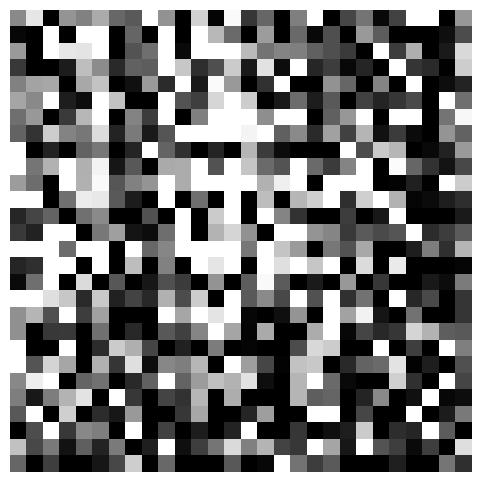

In [11]:

from torchvision.utils import make_grid
import numpy as np
import torch

def alpha_linear_schedule(steps):
    """steps : number of steps
    """
    return torch.linspace(0,1,steps).to(device=device)



def sampler(alpha_schedule,model):

    x_alpha = torch.randn(1,1,28,28).to(device=device)
    t = torch.ones_like(x_alpha).to(device=device)
    for i  in range(1,alpha_schedule.size()[0]):
        alpha_tensor = t*alpha_schedule[i-1]
        x_alpha = x_alpha + (alpha_schedule[i] - alpha_schedule[i-1])*model(x_alpha,alpha_tensor)

    return x_alpha


def sampler_pixel(model:minimalDiffRl_revised,nb_steps=200):
    tensor_temp = torch.ones(32,1,28,28).to(device=device)
    alpha_start = torch.tensor(1.0,device=device)
    alpha_end = torch.tensor(1.0,device=device)
    x_alpha = torch.rand_like(tensor_temp).to(device=device)
    for t in range(nb_steps):
        alpha_start *= (t/nb_steps)
        alpha_end *= ((t+1)/nb_steps)

        tensor_temp*= alpha_start

        x_alpha = x_alpha + (alpha_end - alpha_start)*model(x_alpha,tensor_temp)

    return x_alpha




time_steps = 5000
alphas = alpha_linear_schedule(time_steps)

samples = sampler(alphas,model)


samples = samples.clamp(0.0, 1.0)
import matplotlib.pyplot as plt
%matplotlib inline

sample_grid = make_grid(samples, nrow=int(np.sqrt(32)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1,2,0).cpu(), vmin=0., vmax=1.)
plt.show()